Please upvote, if you found my notebook useful 🤗

In [1]:
# imports
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import random

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from collections import defaultdict
from PIL import Image

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.utils import make_grid

from tqdm.notebook import tqdm

In [27]:
dataset = pd.read_csv('../input/fer2018/fer20131.csv')
dataset.head()
dataset.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [28]:
train_df = dataset[dataset["Usage"] == "Training"]
val_df = dataset[dataset["Usage"] == "PublicTest"]
test_df = dataset[dataset["Usage"] == "PrivateTest"]

In [29]:
class FER2018Dataset(Dataset):
    '''
        Parse raw data to form a Dataset of (X, y).
    '''
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.classes = {0: 'Angry', 
                        1: 'Disgust', 
                        2: 'Fear', 
                        3: 'Happy', 
                        4: 'Sad', 
                        5: 'Surprise', 
                        6: 'Neutral'
                       }
                       
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        label = int(row['emotion'])
        img = np.array(row["pixels"].split(' '), dtype=np.uint8).reshape(48, 48)
        img = np.stack([img] * 3, axis=2) # make a 3-channel RGB image from a grayscale
      

        if self.transform:
            img = self.transform(img)
        
        return {
                'image': torch.tensor(img, dtype=torch.float),
                'label': torch.tensor(label, dtype=torch.long)
            }

In [30]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomRotation(degrees=(-30, 30)),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip()
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = FER2018Dataset(train_df, train_transform)
val_dataset = FER2018Dataset(val_df, test_transform)
test_dataset = FER2018Dataset(test_df, test_transform)

In [31]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=1, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size, num_workers=1, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size, num_workers=1, pin_memory=True)

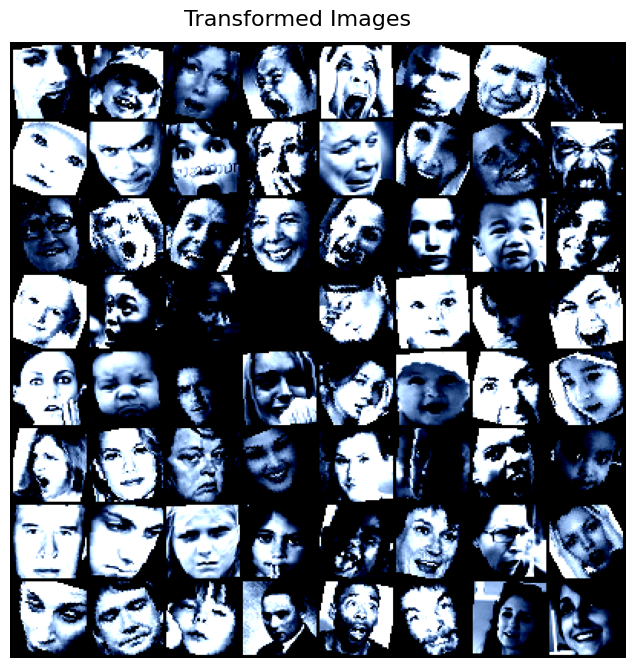

In [32]:
with torch.no_grad():
    data = next(iter(train_dataloader))
    plt.figure(figsize=(16, 8))
    plt.axis("off")
    plt.imshow(make_grid(data["image"].clone().detach(), nrow=8).permute((1, 2, 0))) # move the channel dimension

    _ = plt.suptitle("Transformed Images", y=0.92, fontsize=16)

In [33]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [34]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT) # load pretrained model
model.fc = nn.Linear(512, 7) # since we have 7 classes
model = model.to(device)
# print(model)

In [35]:
# training function
def train(model, dataloader, optimizer, loss_fn):
    model.train()
    train_running_loss = 0.0
    train_running_acc = 0.0
   
    for data in tqdm(dataloader, desc="Training...", total=len(dataloader)):
        images, labels = data['image'].to("cuda"), data['label'].to("cuda")

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        
        train_running_loss += loss.clone().detach()
        train_running_acc += accuracy(outputs.clone().detach(), labels)
        
        loss.backward()
        optimizer.step()
    
    train_loss = train_running_loss / len(dataloader)       
    train_acc = train_running_acc / len(dataloader)

    return train_loss, train_acc

In [36]:
# validation function
def validate(model, dataloader, optimizer, loss_fn):
    model.eval()
    
    valid_running_loss = 0.0
    vaild_running_acc = 0.0
    
    with torch.no_grad():
        for data in tqdm(dataloader, desc="Validating...", total=len(dataloader)):
            images, labels = data['image'].to(device), data['label'].to(device)
           
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            valid_running_loss += loss.clone().detach()
            vaild_running_acc += accuracy(outputs.clone().detach(), labels)
        
    valid_loss = valid_running_loss / len(dataloader)
    valid_acc = vaild_running_acc / len(dataloader)
    
    return valid_loss, valid_acc

In [37]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [38]:
def metricsPlots(train_loss, val_loss, train_acc, val_acc):
    # loss plots
    plt.figure(figsize=(12, 6))

    plt.subplot(121)
    plt.plot(train_loss, color='blue', label='train loss')
    plt.plot(val_loss, color='red', label='validataion loss')
    plt.xlabel('Epochs')
    plt.xticks(range(epochs), range(1, epochs + 1))
    plt.ylabel('Loss')
    plt.legend()


    # accuracy plots
    plt.subplot(122)
    plt.plot(train_acc, color='blue', label='train accuracy')
    plt.plot(val_acc, color='red', label='validataion accuracy')
    plt.xlabel('Epochs')
    plt.xticks(range(epochs), range(1, epochs + 1))
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplots_adjust(wspace=0.25)
    plt.show()

In [39]:
# loss function and optimizer
epochs = 15
lr = 0.005
weight_decay = 0.05
loss_function = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), weight_decay=weight_decay, lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [ ]:
best_val_acc = 0.0  # Inizializza il miglior punteggio di accuratezza sulla validazione

for epoch in range(1, epochs + 1):
    train_epoch_loss, train_epoch_acc = train(model, train_dataloader, optimizer, loss_function)
    val_epoch_loss, val_epoch_acc = validate(model, val_dataloader, optimizer, loss_function)
    scheduler.step(val_epoch_loss)
    
    train_loss.append(train_epoch_loss.detach().cpu().numpy())
    val_loss.append(val_epoch_loss.detach().cpu().numpy())
    train_acc.append(train_epoch_acc.detach().cpu().numpy())
    val_acc.append(val_epoch_acc.detach().cpu().numpy())
    
    print(f'Epoch: {epoch},\
          Train loss: {train_epoch_loss:.4f},\
          Train acc: {train_epoch_acc:.4f},\
          Val loss: {val_epoch_loss:.4f},\
          Val acc: {val_epoch_acc:.4f}\
          ')
    
    if epoch % 5 == 0:
        metricsPlots(train_loss, val_loss, train_acc, val_acc)
    
    # Salva il modello se l'accuratezza sulla validazione è migliorata
    if val_epoch_acc > best_val_acc:
        best_val_acc = val_epoch_acc
        torch.save(model.state_dict(), 'best_model.pth')  # Salva solo i pesi del modello

print('DONE TRAINING')

Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 1,          Train loss: 1.5400,          Train acc: 0.3996,          Val loss: 1.4328,          Val acc: 0.4519          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

In [ ]:
classes = list(test_dataset.classes.values())

# test function
def test(model, dataloader):
    model.eval()
    
    # prepare to count predictions for each class
    correct_pred = defaultdict(int)
    total_pred = defaultdict(int)
    
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for data in tqdm(dataloader, desc="Testing...", total=len(dataloader)):
            images, labels = data['image'].to(device), data['label'].to(device)
           
            outputs = model(images)
            
            _, predictions = torch.max(outputs, 1)
            predictions = predictions.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            all_labels.extend(labels)
            all_predictions.extend(predictions)
            
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    return correct_pred, total_pred, all_labels, all_predictions

correct_pred, total_pred, all_labels, all_predictions = test(model, test_dataloader)


In [ ]:
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.4f}')

total_acc = sum(correct_pred[class_name] for class_name in classes) / len(test_dataset)
print(f"Total accuracy: {total_acc:.4f}")

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues):
    """
    The function is used to construct the confusion matrix 
    """
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(6,6))
    matplotlib.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(matrix) 
    for i in range(0, len(classes)):
        for j in range(0, len(classes)):  
            ax.text(j,i,cm[i,j],va='center', ha='center')
    ticks = np.arange(len(classes))
    ax.set_xticks(ticks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(all_labels, all_predictions, cmap=plt.cm.YlGnBu)
plt.show()